In [20]:
import numpy as np
import sep


In [37]:
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.modeling.models import Rotation2D
%matplotlib inline
from scipy.ndimage import rotate



rcParams['figure.figsize'] = [10., 8.]

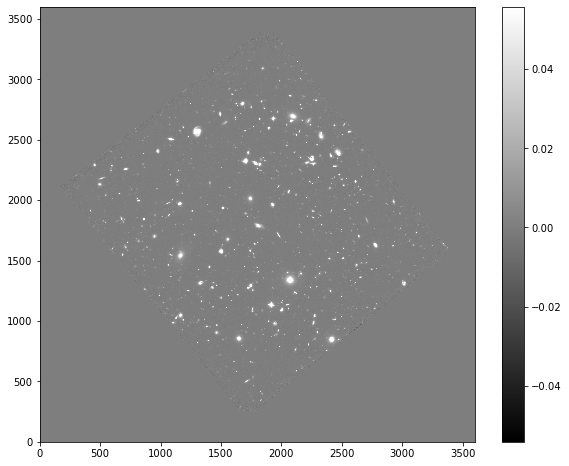

In [22]:
data = fitsio.read("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")

##data = rotate(data, angle=38)
##data = data[1000:4000,1000:4000]
m, s = np.mean(data), np.std(data)


plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();


In [23]:
bkg = sep.Background(data)
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


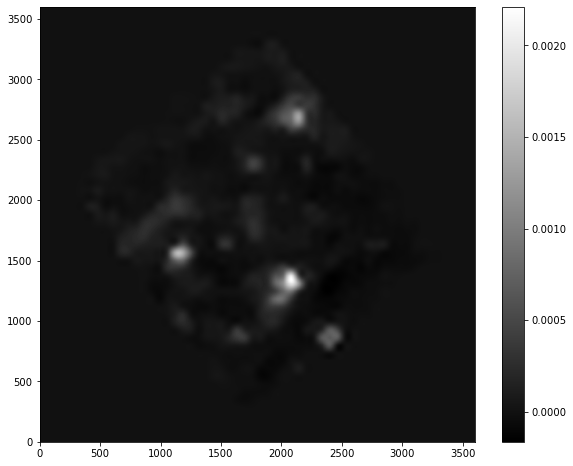

In [24]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("data_background.png",format="png")

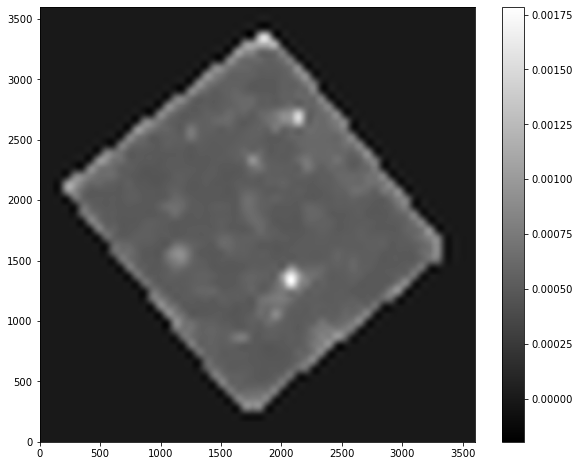

In [25]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("data_noise.png",format="png")

In [26]:
data_sub = data - bkg

objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
# how many objects were detected
len(objects)

8646

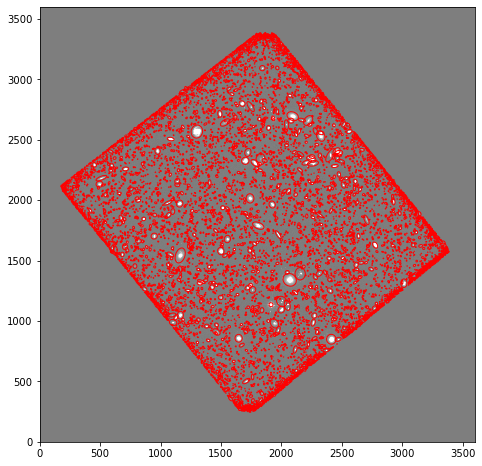

In [27]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

plt.savefig("data_circle.png",format="png")

In [28]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)



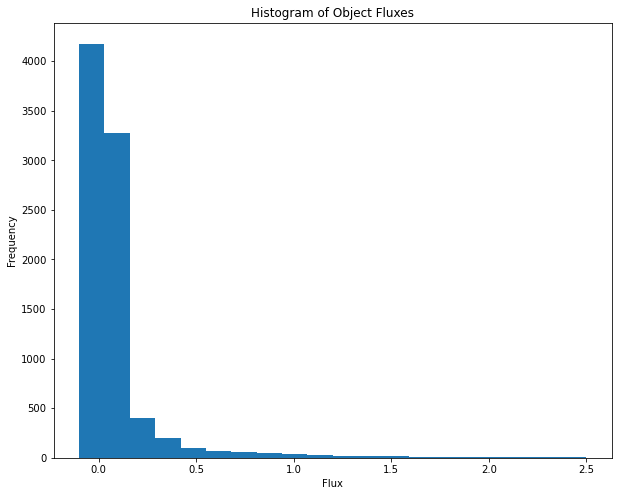

In [36]:
plt.figure()

plt.hist(flux, bins=20, range =(-0.1,2.5))
plt.title('Histogram of Object Fluxes')
plt.xlabel('Flux')
plt.ylabel('Frequency')

# Show the figure
plt.show()

In [30]:
print(f"Mean: {np.mean(flux)}")
print(f"Median: {np.median(flux)}")
print(f"Standard deviation: {np.std(flux)}")
outlier_index = np.argmax(flux)
outlier_flux = flux[outlier_index]
outlier_coordinates = (objects['x'][outlier_index], objects['y'][outlier_index])
outlier_distance_from_mean = (outlier_flux - np.mean(flux)) / np.std(flux)

print(f"Largest outlier flux: {outlier_flux}")
print(f"Coordinates of the largest outlier: {outlier_coordinates}")
print(f"Distance from mean in standard deviations: {outlier_distance_from_mean}")


Mean: 0.36159539075495284
Median: 0.03097589430617518
Standard deviation: 9.24028235192194
Largest outlier flux: 807.2972835731507
Coordinates of the largest outlier: (1914.2549094883857, 1134.3164850742164)
Distance from mean in standard deviations: 87.32803365197564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


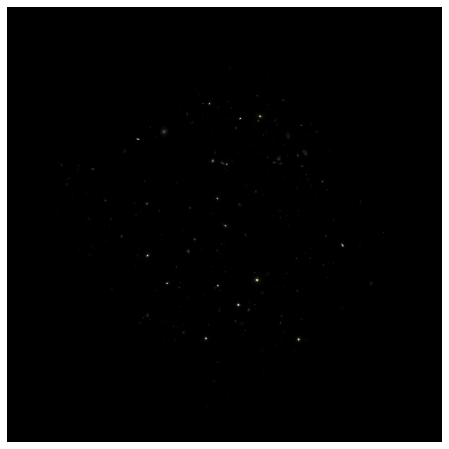

In [49]:
from astropy.visualization import make_lupton_rgb

file1 = fitsio.read("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
file2 = fitsio.read("hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits")
file3 = fitsio.read("hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits")

#rescale
res= np.max(file1)/np.max([np.max(file2), np.max(file3)])
file2_res = file2*res
file3_res = file3*res

rgb = np.stack([file3_res, file2_res, file1],axis=-1)

plt.axis('off')
plt.imshow(rgb,origin="lower")
plt.savefig("3colorImage.png", dpi=300)